<a href="https://colab.research.google.com/github/NidhiMuni/TensorflowQuantumTest/blob/main/mnistRotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# MNIST classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/mnist"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial builds a quantum neural network (QNN) to classify a simplified version of MNIST, similar to the approach used in <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al</a>. The performance of the quantum neural network on this classical data problem is compared with a classical neural network.

## Setup

In [1]:
!pip install tensorflow==2.15.0

Install TensorFlow Quantum:

In [2]:
!pip install tensorflow-quantum==0.7.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.8/598.8 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 50.0 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12.1
    Uninstalling sympy-1.12.1:
      Successfully uninstalled sympy-1.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; pla

In [3]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py'>

Now import TensorFlow and the module dependencies:

In [4]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## 1. Load the data

In this tutorial you will build a binary classifier to distinguish between the digits 3 and 6, following <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> This section covers the data handling that:

- Loads the raw data from Keras.
- Filters the dataset to only 3s and 6s.
- Downscales the images so they fit can fit in a quantum computer.
- Removes any contradictory examples.
- Converts the binary images to Cirq circuits.
- Converts the Cirq circuits to TensorFlow Quantum circuits.

### 1.1 Load the raw data

Load the MNIST dataset distributed with Keras.

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

11490434/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


Filter the dataset to keep just the 3s and 6s,  remove the other classes. At the same time convert the label, `y`, to boolean: `True` for `3` and `False` for 6.

In [6]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [7]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


Show the first example:

True


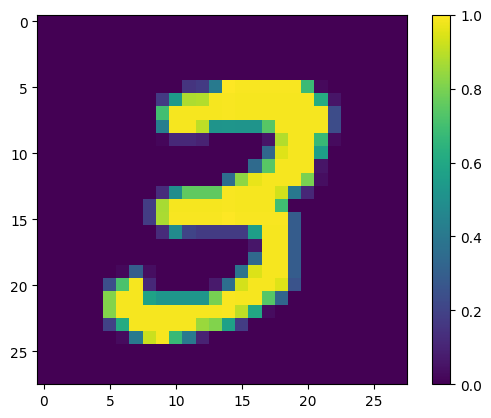

In [8]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

### 1.2 Downscale the images

An image size of 28x28 is much too large for current quantum computers. Resize the image down to 4x4:

In [9]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

Again, display the first training example—after resize:

True


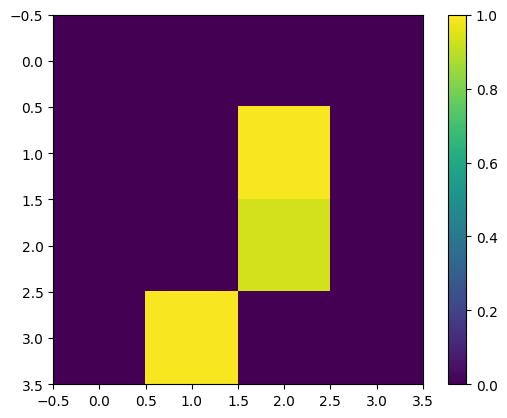

In [10]:
print(y_train[0])

plt.imshow(x_train_small[5,:,:,0], vmin=0, vmax=1)
plt.colorbar()

### 1.3 Remove contradictory examples

From section *3.3 Learning to Distinguish Digits* of <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a>, filter the dataset to remove images that are labeled as belonging to both classes.

This is not a standard machine-learning procedure, but is included in the interest of following the paper.

In [11]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)

The resulting counts do not closely match the reported values, but the exact procedure is not specified.

It is also worth noting here that applying filtering contradictory examples at this point does not totally prevent the model from receiving contradictory training examples: the next step binarizes the data which will cause more collisions.

In [12]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 3 and 6):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


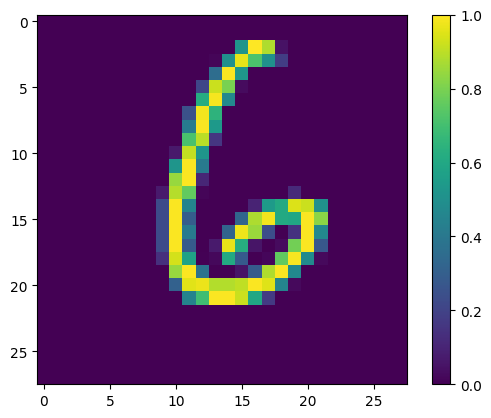

In [13]:
plt.imshow(x_train[7, :, :, 0])
plt.colorbar()

In [14]:
'''plt.imshow(x_train_bin[7,:,:,0], vmin=0, vmax=1)
plt.colorbar()'''

'plt.imshow(x_train_bin[7,:,:,0], vmin=0, vmax=1)\nplt.colorbar()'

### 1.4 Encode the data as quantum circuits

To process images using a quantum computer, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed representing each pixel with a qubit, with the state depending on the value of the pixel. The first step is to convert to a binary encoding.

In [84]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

If you were to remove contradictory images at this point you would be left with only 193, likely not enough for effective training.

In [85]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 193
Number of unique 3s:  80
Number of unique 6s:  69
Number of unique contradicting labels (both 3 and 6):  44

Initial number of images:  10338
Remaining non-contradicting unique images:  149


The qubits at pixel indices with values that exceed a threshold, are rotated through an $X$ gate.

In [86]:
  def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    '''values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(1, 8)
    circuit = cirq.Circuit()

    k = 0
    for qub in range(0, 8):
      circuit.append(cirq.ry(values[k])(cirq.GridQubit(1, qub)))
      try:
        circuit.append(cirq.rz(values[k + 1])(cirq.GridQubit(1, qub)))
      except IndexError:
        circuit.append(cirq.rz(0)(cirq.GridQubit(1, qub)))
      k += 2

    return circuit'''
    '''row = image
    values = (np.ndarray.flatten(row).astype(np.float32) - 1) / 999
    values = values * (2 * np.pi) - np.pi
    qubits = cirq.GridQubit.rect(1, len(values))
    circuit = cirq.Circuit(cirq.rx(v)(q) for v,q in zip(values, qubits))
    return circuit'''

    values = (np.ndarray.flatten(image).astype(np.float32) - 0.5) * 2.0
    qubits = cirq.GridQubit.rect(1, len(values))
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        circuit.append(cirq.rx(value)(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

In [87]:
'''

circuit = cirq.Circuit()


k = 0
for qub in range(qubit_start, qubit_end):
  circuit.append(cirq.ry(values[k])(cirq.LineQubit(qub)))
  try:
    circuit.append(cirq.rz(values[k + 1])(cirq.LineQubit(qub)))
  except IndexError:
    circuit.append(cirq.rz(0)(cirq.LineQubit(qub)))
  k += 2

'''

'\n\ncircuit = cirq.Circuit()\n\n\nk = 0\nfor qub in range(qubit_start, qubit_end):\n  circuit.append(cirq.ry(values[k])(cirq.LineQubit(qub)))\n  try:\n    circuit.append(cirq.rz(values[k + 1])(cirq.LineQubit(qub)))\n  except IndexError:\n    circuit.append(cirq.rz(0)(cirq.LineQubit(qub)))\n  k += 2\n\n'

In [89]:
image = x_train_bin[7]
values = np.ndarray.flatten(image)
qubits = cirq.GridQubit.rect(1, 8)
circuit = cirq.Circuit()

k = 0
for qub in range(0, 8):
  circuit.append(cirq.ry(values[k])(cirq.GridQubit(1, qub)))
  try:
    circuit.append(cirq.rz(values[k + 1])(cirq.GridQubit(1, qub)))
  except IndexError:
    circuit.append(cirq.rz(0)(cirq.GridQubit(1, qub)))
  k += 2

In [90]:
row = x_train_bin[7]
values = (np.ndarray.flatten(row).astype(np.float32) - 1) / 999
values = values * (2 * np.pi) - np.pi
qubits = cirq.GridQubit.rect(1, len(values))
circuit = cirq.Circuit(cirq.rx(v)(q) for v,q in zip(values, qubits))

Here is the circuit created for the first example (circuit diagrams do not show qubits with zero gates):

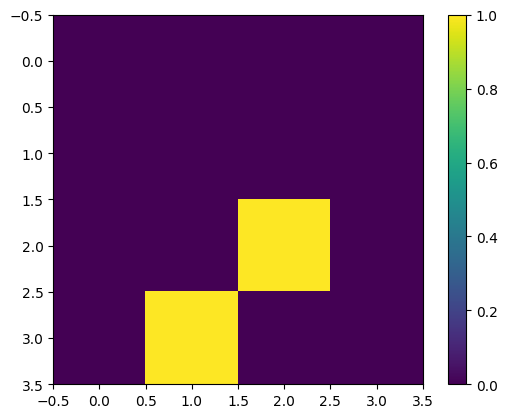

In [21]:
plt.imshow(x_train_bin[15,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [ ]:
SVGCircuit(x_train_circ[12])

Compare this circuit to the indices where the image value exceeds the threshold:

In [91]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

Convert these `Cirq` circuits to tensors for `tfq`:

In [92]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [93]:
x_train_circ[7]

(0, 0): ────Rx(-0.318π)───

(0, 1): ────Rx(-0.318π)───

(0, 2): ────Rx(0.318π)────

(0, 3): ────Rx(-0.318π)───

(0, 4): ────Rx(-0.318π)───

(0, 5): ────Rx(-0.318π)───

(0, 6): ────Rx(-0.318π)───

(0, 7): ────Rx(-0.318π)───

(0, 8): ────Rx(-0.318π)───

(0, 9): ────Rx(0.318π)────

(0, 10): ───Rx(-0.318π)───

(0, 11): ───Rx(-0.318π)───

(0, 12): ───Rx(-0.318π)───

(0, 13): ───Rx(-0.318π)───

(0, 14): ───Rx(-0.318π)───

(0, 15): ───Rx(-0.318π)───

In [40]:
'''tensor_value = x_train_tfcirc[1].numpy()  # Get the tensor value as bytes

# Decode protobuf message
parsed_message = tf.io.parse_single_example(tensor_value, features={
    'key': tf.io.FixedLenFeature([], dtype=tf.string),  # Example, adjust based on actual schema
})

print(parsed_message)'''

"tensor_value = x_train_tfcirc[1].numpy()  # Get the tensor value as bytes\n\n# Decode protobuf message\nparsed_message = tf.io.parse_single_example(tensor_value, features={\n    'key': tf.io.FixedLenFeature([], dtype=tf.string),  # Example, adjust based on actual schema\n})\n\nprint(parsed_message)"

## 2. Quantum neural network

There is little guidance for a quantum circuit structure that classifies images. Since the classification is based on the expectation of the readout qubit, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> propose using two qubit gates, with the readout qubit always acted upon. This is similar in some ways to running small a <a href="https://arxiv.org/abs/1511.06464" class="external">Unitary RNN</a> across the pixels.

### 2.1 Build the model circuit

This following example shows this layered approach. Each layer uses *n* instances of the same gate, with each of the data qubits acting on the readout qubit.

Start with a simple class that will add a layer of these gates to a circuit:

In [95]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

Build an example circuit layer to see how it looks:

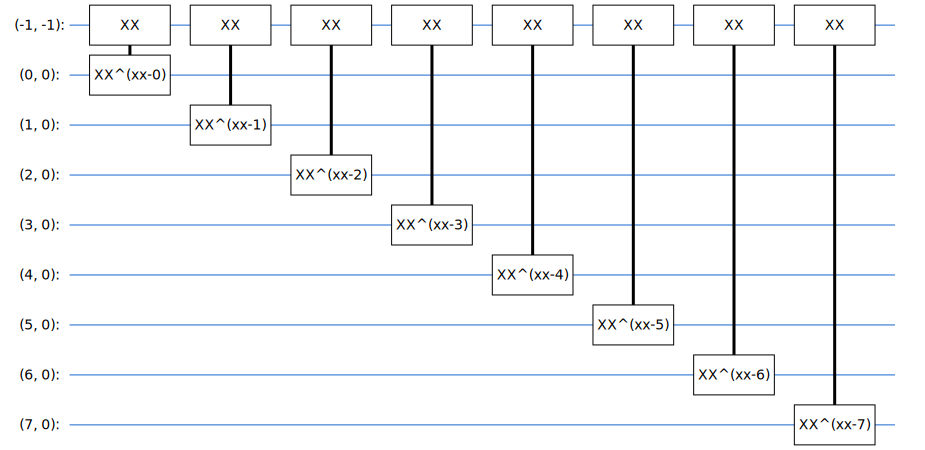

In [42]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(8,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

Now build a two-layered model, matching the data-circuit size, and include the preparation and readout operations.

In [96]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(1, 16)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [97]:
model_circuit, model_readout = create_quantum_model()

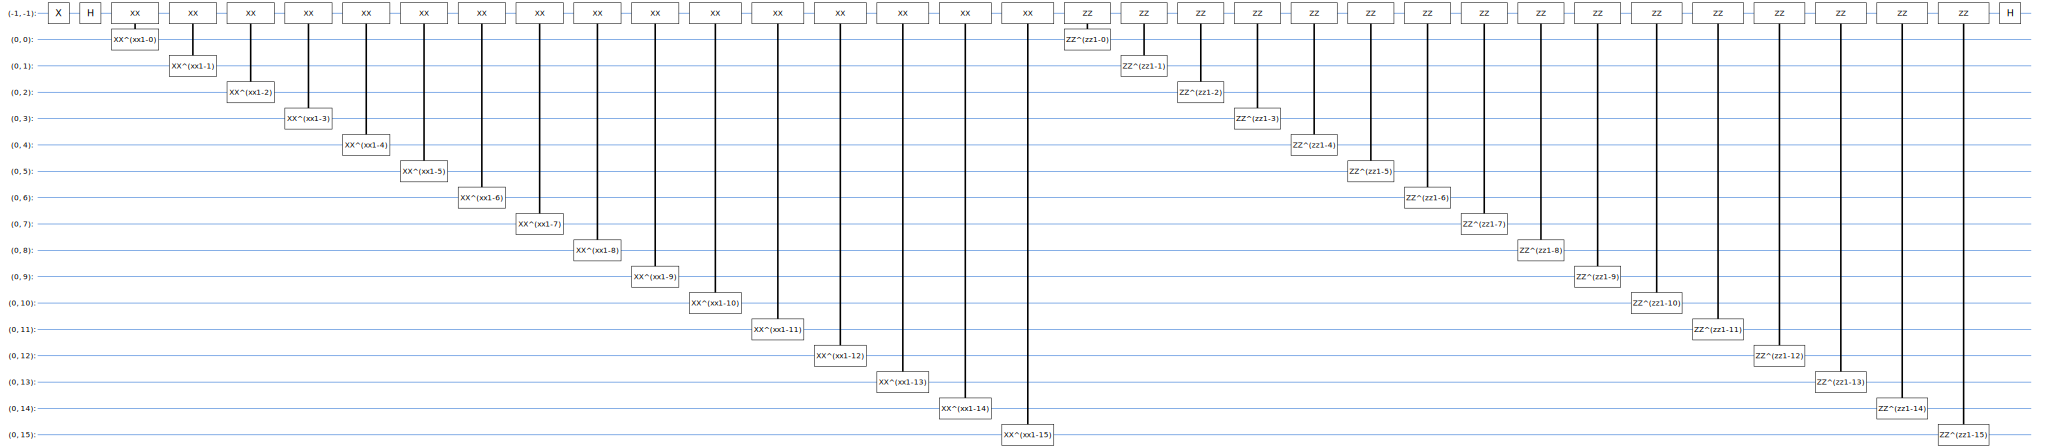

In [45]:
SVGCircuit(model_circuit)

### 2.2 Wrap the model-circuit in a tfq-keras model

Build the Keras model with the quantum components. This model is fed the "quantum data", from `x_train_circ`, that encodes the classical data. It uses a *Parametrized Quantum Circuit* layer, `tfq.layers.PQC`, to train the model circuit, on the quantum data.

To classify these images, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed taking the expectation of a readout qubit in a parameterized circuit. The expectation returns a value between 1 and -1.

In [98]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Next, describe the training procedure to the model, using the `compile` method.

Since the the expected readout is in the range `[-1,1]`, optimizing the hinge loss is a somewhat natural fit.

Note: Another valid approach would be to shift the output range to `[0,1]`, and treat it as the probability the model assigns to class `3`. This could be used with a standard a `tf.losses.BinaryCrossentropy` loss.

To use the hinge loss here you need to make two small adjustments. First convert the labels, `y_train_nocon`, from boolean to `[-1,1]`, as expected by the hinge loss.

In [99]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

Second, use a custiom `hinge_accuracy` metric that correctly handles `[-1, 1]` as the `y_true` labels argument.
`tf.losses.BinaryAccuracy(threshold=0.0)` expects `y_true` to be a boolean, and so can't be used with hinge loss).

In [100]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [101]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [102]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc_2 (PQC)                 (None, 1)                 32        
                                                                 
Total params: 32 (128.00 Byte)
Trainable params: 32 (128.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


### Train the quantum model

Now train the model—this takes about 45 min. If you don't want to wait that long, use a small subset of the data (set `NUM_EXAMPLES=500`, below). This doesn't really affect the model's progress during training (it only has 32 parameters, and doesn't need much data to constrain these). Using fewer examples just ends training earlier (5min), but runs long enough to show that it is making progress in the validation logs.

In [103]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = 500 #len(x_train_tfcirc)

In [104]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

Training this model to convergence should achieve >85% accuracy on the test set.

In [105]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
16/16 [==============================] - 149s 10s/step - loss: 0.9976 - hinge_accuracy: 0.6246 - val_loss: 0.9902 - val_hinge_accuracy: 0.8130
Epoch 2/3
16/16 [==============================] - 148s 10s/step - loss: 0.9866 - hinge_accuracy: 0.7801 - val_loss: 0.9846 - val_hinge_accuracy: 0.7510
Epoch 3/3
62/62 [==============================] - 45s 714ms/step - loss: 0.9761 - hinge_accuracy: 0.7152


Note: The training accuracy reports the average over the epoch. The validation accuracy is evaluated at the end of each epoch.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)

x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

_ = remove_contradicting(x_train_bin, y_train_nocon)

  def convert_to_circuit(image):
    row = image
    values = (np.ndarray.flatten(row).astype(np.float32) - 1) / 999
    values = values * (2 * np.pi) - np.pi
    qubits = cirq.GridQubit.rect(1, len(values))
    circuit = cirq.Circuit(cirq.rx(v)(q) for v,q in zip(values, qubits))
    return circuit

x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(1, 16)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

model_circuit, model_readout = create_quantum_model()

# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = 500 #len(x_train_tfcirc)
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)